<a href="https://colab.research.google.com/github/Mehedihasan097/Reinforcement-Learning/blob/main/Pricing_Policy_Optimization_Using_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qbstyles # install the missing qbstyles module
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from qbstyles import mpl_style
mpl_style(dark=False)

<ipython-input-6-30e2a68cc325>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
print(Transition)

<class '__main__.Transition'>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost)

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )

**Visualization Functions**

In [ ]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)

    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

Episode 0 of 10 (0.00%)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Best profit results: -1028956.8186260137
Best profit results: -890473.404308333
Best profit results: -594045.1538013043
Best profit results: -578556.9940808986
Best profit results: -427130.4494357342
Best profit results: 222605.8

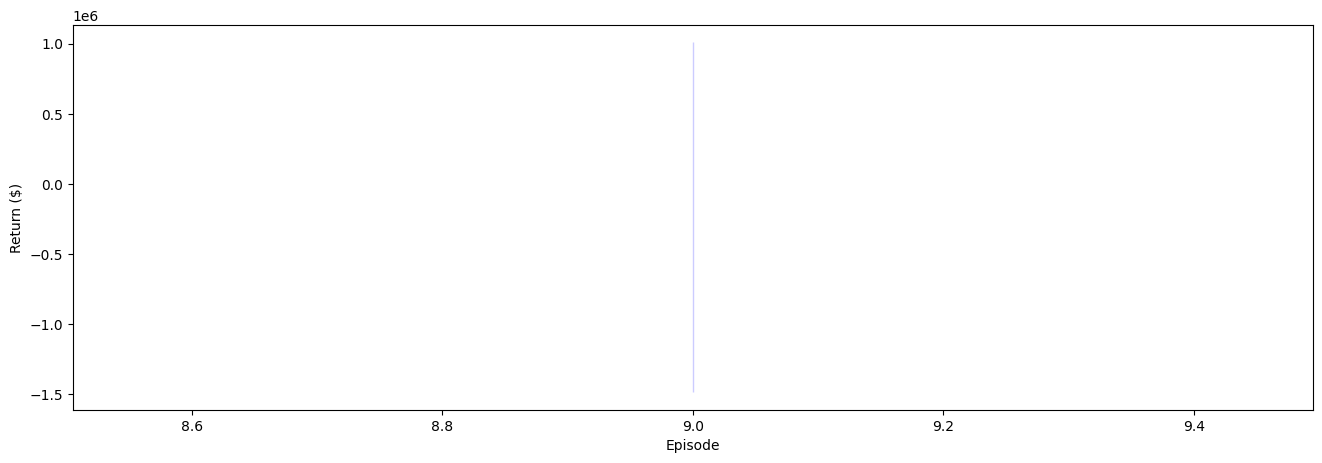

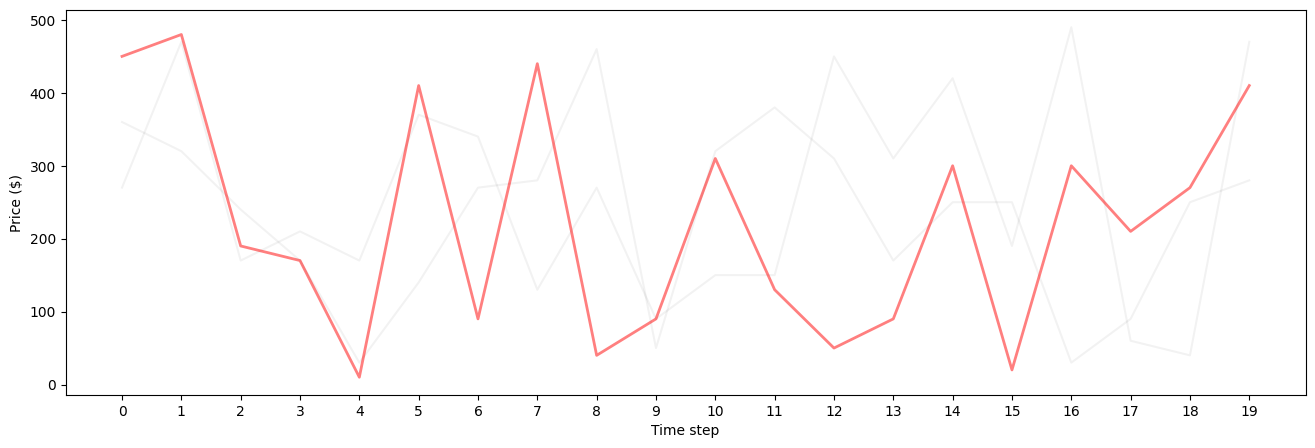

In [ ]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values

class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
    print(np.repeat(0, 2*T))
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1])
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 10
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state),
                    to_tensor_long(action),
                    to_tensor(next_state) if t != T - 1 else None,
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
    print(f'Best profit results: {profit}')

In [ ]:
!pip install gym
#!pip install ray[rllib]
!pip install ray[tune]


In [ ]:
!pip install ray[rllib]==2.0.0 pydantic==1.10.9

In [ ]:
import gym
from gym.spaces import Discrete, Box

import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

/usr/local/lib/python3.10/dist-packages/ray/tune/logger/tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
2024-09-19 10:43:30,662	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.dqn` has been deprecated. Use `ray.rllib.algorithms.[dqn|simple_q|r2d2|apex_dqn]` instead. This will raise an error in the future!


In [ ]:
class HiLoPricingEnv(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Discrete(len(price_grid))
        self.observation_space = Box(0, 10000, shape=(2*T, ), dtype=np.float32)

    def reset(self):
        self.state = env_intial_state()
        self.t = 0
        return self.state

    def step(self, action):
        next_state, reward = env_step(self.t, state, action)
        self.t += 1
        self.state = next_state
        return next_state, reward, self.t == T - 1, {}

ray.shutdown()
ray.init()

def train_dqn():
    config = dqn.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["lr"] = 0.002
    config["gamma"] = 0.80
    config["train_batch_size"] = 256
    config["replay_buffer_config"] = {'capacity': 10000}
    config["timesteps_per_iteration"] = 5000
    config["hiddens"] = [128, 128, 128]
    config["exploration_config"] = {'final_epsilon': 0.01}
    trainer = dqn.DQNTrainer(config=config, env=HiLoPricingEnv)
    for i in range(50):
        result = trainer.train()
        print(pretty_print(result))

train_dqn()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-19 11:14:58,866	INFO worker.py:1518 -- Started a local Ray instance.
2024-09-19 11:15:03,089	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
2024-09-19 11:15:03,094	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/_private/ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memor

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


TypeError: RandomNumberGenerator._generator_ctor() takes from 0 to 1 positional arguments but 2 were given